<a href="https://colab.research.google.com/github/RaniaBouchrara/Stage-Rania/blob/master/stage_Rania.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Simulation de dynamiques (séries temporelles) Lorenz_63 déterministe

In [0]:
import numpy as np

def Lorenz_63(S,t,Pra,r,b,gamma):
    """ Lorenz-63 dynamical model. """
    x_1 = Pra*(S[1]-S[0])-(4/(2*gamma))*S[0];
    x_2 = S[0]*(r-S[2])-S[1]-(4/(2*gamma))*S[1];
    x_3 = S[0]*S[1] - b*S[2]-(8/(2*gamma))*S[2];
    dS  = np.array([x_1,x_2,x_3]);
    return dS

In [0]:
from scipy.integrate import odeint
from scipy.integrate import ode
def generate_data(GD):
    """ Generate the true state, noisy observations and catalog of numerical simulations. """

    # initialization
    class xt:
        values = [];
        time = [];
    class yo:
        values = [];
        time = [];
    class catalog:
        analogs = [];
        successors = [];
        source = [];
        time = [];
    
    # test on parameters
    if GD.dt_states>GD.dt_obs:
        print('Error: GD.dt_obs must be bigger than GD.dt_states');
    if (np.mod(GD.dt_obs,GD.dt_states)!=0):
        print('Error: GD.dt_obs must be a multiple of GD.dt_states');

    # use this to generate the same data for different simulations
    np.random.seed(1);

    # 5 time steps (to be in the attractor space)  
    x0 = np.array([8.0,0.0,30.0]);
    S = odeint(Lorenz_63,x0,np.arange(0,5+0.000001,GD.dt_integration),args=(GD.parameters.Pra,GD.parameters.r,GD.parameters.b,GD.parameters.gamma));
    x0 = S[S.shape[0]-1,:];

    # generate true state (xt)
    S = odeint(Lorenz_63,x0,np.arange(0.01,GD.nb_loop_test+0.000001,GD.dt_integration),args=(GD.parameters.Pra,GD.parameters.r,GD.parameters.b,GD.parameters.gamma));
    T_test = S.shape[0];      
    t_xt = np.arange(0,T_test,GD.dt_states);       
    xt.time = t_xt*GD.dt_integration;
    xt.values = S[t_xt,:];
        
    # generate  partial/noisy observations (yo)
    eps = np.random.multivariate_normal(np.zeros(3),GD.sigma2_obs*np.eye(3,3),T_test);
    yo_tmp = S[t_xt,:]+eps[t_xt,:];
    t_yo = np.arange(0,T_test,GD.dt_obs);
    i_t_obs = np.where((np.in1d(t_xt,t_yo))==True)[0];
    yo.values = xt.values*np.nan;
    yo.values[np.ix_(i_t_obs,GD.var_obs)] = yo_tmp[np.ix_(i_t_obs,GD.var_obs)];
    yo.time = xt.time;
       

    #generate catalog
    S =  odeint(Lorenz_63,S[S.shape[0]-1,:],np.arange(0.01,GD.nb_loop_train+0.000001,GD.dt_integration),args=(GD.parameters.Pra,GD.parameters.r,GD.parameters.b,GD.parameters.gamma));
    T_train = S.shape[0];
    eta = np.random.multivariate_normal(np.zeros(3),GD.sigma2_catalog*np.eye(3,3),T_train);
    catalog_tmp = S+eta;
    catalog.analogs = catalog_tmp[0:-GD.dt_states,:];
    catalog.successors = catalog_tmp[GD.dt_states:,:]
    catalog.source = GD.parameters;
  # reinitialize random generator number    
    np.random.seed()

    return catalog, xt, yo;

In [0]:
import sys
import matplotlib.pyplot as plt
import torch
from mpl_toolkits.mplot3d import Axes3D

In [0]:
### GENERATE SIMULATED DATA (LORENZ-63 MODEL)
class GD:
    model = 'Lorenz_63'
    class parameters:
        Pra = 10.0
        r = 28.0
        b = 8.0/3
        gamma=10.0
    dt_integration = 0.01 # integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0,1]) # indices of the observed variables
    nb_loop_train = 110.01 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 0.0 # variance of the observation error to generate observation
    
# run the data generation
catalog, xt, yo = generate_data(GD)

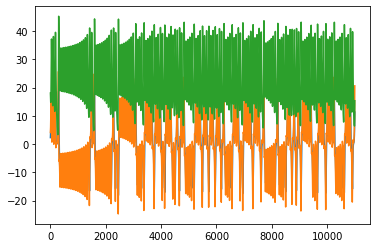

In [5]:
plt.plot(catalog.analogs)

In [0]:
#training data
batch_size = 50
X_train = np.reshape(catalog.analogs,(int(catalog.analogs.shape[0]/batch_size),batch_size,catalog.analogs.shape[1]))
Grad_t  = np.gradient(X_train)[1]/GD.dt_integration
Y_train = np.reshape(catalog.successors,(int(catalog.analogs.shape[0]/batch_size),batch_size,catalog.analogs.shape[1]))

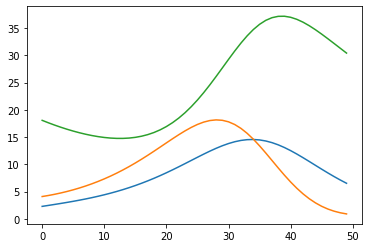

In [7]:
plt.plot(X_train[0,:,:])

In [0]:
params = {}#NN parameters
params['transition_layers']=1
params['bi_linear_layers']=3
params['dim_hidden_linear'] = 3
params['dim_input']=3
params['dim_output']=3
params['dim_observations'] = 3
params['dim_hidden']=3
params['ntrain']=[1000,200]
params['dt_integration'] = GD.dt_integration
pretrained = False
path = ''# to be defined
file_name = '' # to be defined

In [0]:
np.random.seed(0)
torch.manual_seed(0)
class FC_net(torch.nn.Module):
        def __init__(self, params):
            super(FC_net, self).__init__()
            self.linearCell   = torch.nn.Linear(params['dim_input'], params['dim_hidden_linear']) 
            self.BlinearCell1 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1) for i in range(params['bi_linear_layers'])])
            self.BlinearCell2 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1) for i in range(params['bi_linear_layers'])])
            augmented_size    = params['bi_linear_layers'] + params['dim_hidden_linear']
            self.transLayers = torch.nn.ModuleList([torch.nn.Linear(augmented_size, params['dim_input'])])
            self.transLayers.extend([torch.nn.Linear(params['dim_input'],params['dim_input']) for i in range(1, params['transition_layers'])])
            self.outputLayer  = torch.nn.Linear(params['dim_input'], params['dim_input']) 
        def forward(self, inp, dt):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            aug_inp = inp
            BP_outp = (torch.zeros((aug_inp.size()[0],params['bi_linear_layers'])))
            L_outp   = self.linearCell(aug_inp)
            for i in range((params['bi_linear_layers'])):
                BP_outp[:,i]=self.BlinearCell1[i](aug_inp)[:,0]*self.BlinearCell2[i](aug_inp)[:,0]
            aug_vect = torch.cat((L_outp, BP_outp), dim=1)
            for i in range((params['transition_layers'])):
                aug_vect = (self.transLayers[i](aug_vect))
            grad = self.outputLayer(aug_vect)
            return grad
model  = FC_net(params)

In [0]:
class INT_net(torch.nn.Module):
        def __init__(self, params):
            super(INT_net, self).__init__()
#            self.add_module('Dyn_net',FC_net(params))
            self.Dyn_net = model
        def forward(self, inp, dt):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k1 = self.Dyn_net(inp,dt)
            inp_k2      = inp + 0.5*params['dt_integration']*k1
            k2     = self.Dyn_net(inp_k2,dt)
            inp_k3      = inp + 0.5*params['dt_integration']*k2       
            k3     = self.Dyn_net(inp_k3,dt)
            inp_k4      = inp + params['dt_integration']*k3          
            k4     = self.Dyn_net(inp_k4,dt)            
            pred = inp +dt*(k1+2*k2+2*k3+k4)/6    
            return pred, k1

In [0]:
dt = params['dt_integration']
aug_vect = []
x = torch.from_numpy(X_train).float()
y = torch.from_numpy(Y_train).float()
z = torch.from_numpy(Grad_t).float()

modelRINN = INT_net(params)
criterion = torch.nn.MSELoss(reduction='elementwise_mean')
optimizer = torch.optim.Adam(modelRINN.parameters(),lr = 0.001)

if pretrained :
    modelRINN.load_state_dict(torch.load(path + file_name))

In [12]:
print ('Learning Dynamical model')        
for t in range(params['ntrain'][0]):
    for b in range(x.shape[0]):
        # Forward pass: Compute predicted y by passing x to the model
        pred, grad = modelRINN(x[b,:,:],params['dt_integration'])
        # Compute and print loss
        loss = criterion(grad, z[b,:,:])
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Save models
        #torch.save(modelRINN.state_dict(), path + file_name)
    print(t,loss)

Learning Dynamical model


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:13: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


0 tensor(2167.7939, grad_fn=<MseLossBackward>)
1 tensor(1198.2394, grad_fn=<MseLossBackward>)
2 tensor(1420.5103, grad_fn=<MseLossBackward>)
3 tensor(1438.4559, grad_fn=<MseLossBackward>)
4 tensor(1158.2849, grad_fn=<MseLossBackward>)
5 tensor(952.7786, grad_fn=<MseLossBackward>)
6 tensor(770.1275, grad_fn=<MseLossBackward>)
7 tensor(600.9072, grad_fn=<MseLossBackward>)
8 tensor(450.3810, grad_fn=<MseLossBackward>)
9 tensor(325.1045, grad_fn=<MseLossBackward>)
10 tensor(228.3890, grad_fn=<MseLossBackward>)
11 tensor(159.1411, grad_fn=<MseLossBackward>)
12 tensor(112.8520, grad_fn=<MseLossBackward>)
13 tensor(83.5495, grad_fn=<MseLossBackward>)
14 tensor(65.5145, grad_fn=<MseLossBackward>)
15 tensor(54.1657, grad_fn=<MseLossBackward>)
16 tensor(46.2266, grad_fn=<MseLossBackward>)
17 tensor(39.5271, grad_fn=<MseLossBackward>)
18 tensor(32.7767, grad_fn=<MseLossBackward>)
19 tensor(25.7187, grad_fn=<MseLossBackward>)
20 tensor(19.9789, grad_fn=<MseLossBackward>)
21 tensor(18.8498, grad_fn

In [13]:
print ('Optimizing flowmap')        
for t in range(params['ntrain'][1]):
    for b in range(x.shape[0]):
        # Forward pass: Compute predicted y by passing x to the model
        pred, grad = modelRINN(x[b,:,:],params['dt_integration'])
        # Compute and print loss
        loss = criterion(pred, y[b,:,:])
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Save models
        #torch.save(modelRINN.state_dict(), path + file_name)
    print(t,loss)

Optimizing flowmap


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:13: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


0 tensor(2.5277e-05, grad_fn=<MseLossBackward>)
1 tensor(2.3475e-05, grad_fn=<MseLossBackward>)
2 tensor(2.1621e-05, grad_fn=<MseLossBackward>)
3 tensor(1.9730e-05, grad_fn=<MseLossBackward>)
4 tensor(1.7821e-05, grad_fn=<MseLossBackward>)
5 tensor(1.5914e-05, grad_fn=<MseLossBackward>)
6 tensor(1.4044e-05, grad_fn=<MseLossBackward>)
7 tensor(1.2227e-05, grad_fn=<MseLossBackward>)
8 tensor(1.0497e-05, grad_fn=<MseLossBackward>)
9 tensor(8.8786e-06, grad_fn=<MseLossBackward>)
10 tensor(7.3909e-06, grad_fn=<MseLossBackward>)
11 tensor(6.0591e-06, grad_fn=<MseLossBackward>)
12 tensor(4.8929e-06, grad_fn=<MseLossBackward>)
13 tensor(3.8987e-06, grad_fn=<MseLossBackward>)
14 tensor(3.0723e-06, grad_fn=<MseLossBackward>)
15 tensor(2.4051e-06, grad_fn=<MseLossBackward>)
16 tensor(1.8845e-06, grad_fn=<MseLossBackward>)
17 tensor(1.4928e-06, grad_fn=<MseLossBackward>)
18 tensor(1.2151e-06, grad_fn=<MseLossBackward>)
19 tensor(1.0257e-06, grad_fn=<MseLossBackward>)
20 tensor(9.0367e-07, grad_fn=

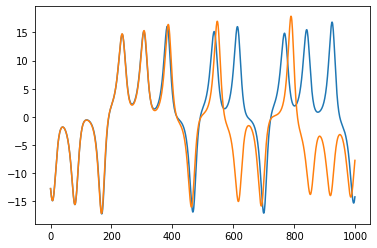

In [14]:
pred = [torch.from_numpy(xt.values[:1,:]).float()]
for i in range(1000):
    pred.append(modelRINN(pred[-1],params['dt_integration'])[0])

plt.plot(torch.stack(pred).data.numpy()[:1000,0,0],label = "Prediction from LQM Dynamical model")
plt.plot(xt.values[:1000,0],label = "True state")

### RINN

In [0]:
import torch.nn.functional as F
from torch.autograd import Variable

def RINN_model(X_train, Y_train, Grad_t, params, order, pretrained, path):
    
    class applyRK_Constraints(object):
        def __init__(self, frequency=1):
            self.frequency = frequency
    
        def __call__(self, module):
            if hasattr(module, 'b'):
                module.b.data = (torch.abs(module.b.data))
                module.b.data  =  ((module.b.data) / (module.b.data).sum(1,keepdim = True).expand_as(module.b.data))
            if hasattr(module, 'c'):
                module.c.data = module.c.data
                module.c.data[:,0] = 0
                module.c.data = module.c.data.sub_(torch.min(module.c.data)).div_(torch.max(module.c.data) - torch.min(module.c.data)).sort()[0]
    torch.manual_seed(1234)
    np.random.seed(1234)    
    class FC_net(torch.nn.Module):
        def __init__(self, params):
            super(FC_net, self).__init__()
            self.linearCell   = torch.nn.Linear(params['dim_input'], params['dim_hidden_linear']) 
            self.BlinearCell1 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1) for i in range(params['bi_linear_layers'])])
            self.BlinearCell2 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1) for i in range(params['bi_linear_layers'])])
            augmented_size    = params['bi_linear_layers'] + params['dim_hidden_linear']
            self.transLayers = torch.nn.ModuleList([torch.nn.Linear(augmented_size, params['dim_output'])])
            self.transLayers.extend([torch.nn.Linear(params['dim_output'], params['dim_output']) for i in range(1, params['transition_layers'])])
            self.outputLayer  = torch.nn.Linear(params['dim_output'], params['dim_output']) 
        def forward(self, inp):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            BP_outp = Variable(torch.zeros((inp.size()[0],params['bi_linear_layers'])))
            L_outp   = self.linearCell(inp)
            for i in range((params['bi_linear_layers'])):
                BP_outp[:,i]=self.BlinearCell1[i](inp)[:,0]*self.BlinearCell2[i](inp)[:,0]
            aug_vect = torch.cat((L_outp, BP_outp), dim=1)
            for i in range((params['transition_layers'])):
                aug_vect = (self.transLayers[i](aug_vect))
            grad = self.outputLayer(aug_vect)
            return grad
    model  = FC_net(params)
    class INT_net(torch.nn.Module):
        def __init__(self, params,order):
            super(INT_net, self).__init__()
            self.Dyn_net = model
            a = np.tril(np.random.uniform(size=(params['dim_observations'],order,order)),k=-1)
            b = np.random.uniform(size=(params['dim_observations'],order))
            c = np.random.uniform(size=(params['dim_observations'],order))
            self.a = torch.nn.Parameter(torch.from_numpy(a[:,:,:]).float())
            self.b = torch.nn.Parameter(torch.from_numpy(b).float())
            self.c = torch.nn.Parameter(torch.from_numpy(c).float())

        def forward(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net(inp))]
            for i in range(1,order):
                coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net(rk_inp))
            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            return pred ,k[0], inp

    x = Variable(torch.from_numpy(X_train).float())
    y = Variable(torch.from_numpy(Y_train).float())
    z = Variable(torch.from_numpy(Grad_t).float())
    # Construct our model by instantiating the class defined above
    
    modelRINN = INT_net(params,order)
    # Construct our loss function and an Optimizer. The call to model.parameters()

    if pretrained :
        modelRINN.load_state_dict(torch.load(path))
    criterion = torch.nn.MSELoss(reduction = 'elementwise_mean')
    optimizer = torch.optim.Adam(modelRINN.parameters(), lr = params['lr'],weight_decay=0.1)
    optimizer.param_groups[0]['params'].append(modelRINN.a)
    optimizer.param_groups[0]['params'].append(modelRINN.b)
    optimizer.param_groups[0]['params'].append(modelRINN.c)    

    clipper = applyRK_Constraints()    
    print ('Learning dynamical model')
    for t in range(params['ntrain'][0]):
        for b in range(x.shape[0]):
            # Forward pass: Compute predicted gradients by passing x to the model
            pred ,grad , inp = modelRINN(x[b,:,:],params['dt_integration'],order)
            # Compute and print loss
            loss = criterion(grad, z[b,:,:])
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
        print(t,loss)

    print ('Learning prediction model')   
    modelRINN.apply(clipper)     
    for t in range(params['ntrain'][1]):
        for b in range(x.shape[0]):
        # Forward pass: Compute predicted states by passing x to the model
            pred ,grad , inp = modelRINN(x[b,:,:],params['dt_integration'],order)
            # Compute and print loss
            loss1 = criterion(pred, y[b,:,:])
            #loss2 = criterion(grad, z[b,:,:])
            loss = 1.0*loss1
            if loss.data.numpy()<1000 and not (np.isnan(loss.data.numpy())):
                # Zero gradients, perform a backward pass, and update the weights.
                optimizer.zero_grad() 
                loss.backward()
                optimizer.step()
                torch.nn.utils.clip_grad_norm_(modelRINN.parameters(),5)
                #modelRINN.apply(clipper)
                if t % clipper.frequency == 0:
                    modelRINN.apply(clipper)     
        print(t,loss)        
    return modelRINN

In [0]:
#training data
batch_size = 100
X_train = np.reshape(catalog.analogs,(int(catalog.analogs.shape[0]/batch_size),batch_size,catalog.analogs.shape[1]))
Grad_t  = np.gradient(X_train)[1]/GD.dt_integration
Y_train = np.reshape(catalog.successors,(int(catalog.analogs.shape[0]/batch_size),batch_size,catalog.analogs.shape[1]))

In [0]:
order=4 #number of stages of the runge kutta scheme (11)

params = {}#NN parameters 
params['transition_layers']=1
params['bi_linear_layers']=3
params['dim_hidden_linear'] = 3
params['dim_input']=3
params['dim_observations'] = 3
params['dim_output']=3
params['dim_hidden']=3
params['dt_integration']=GD.dt_integration
params['ntrain']=[100,1000]
params['lr']=0.001
pretrained = False
path = ''

### Learn dynamical and integration models, stop when loss ~ 0.2

In [18]:
dyn_mdl = RINN_model(X_train, Y_train, Grad_t, params, order, pretrained ,path)

Learning dynamical model


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:13: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


0 tensor(3804.0576, grad_fn=<MseLossBackward>)
1 tensor(3103.0867, grad_fn=<MseLossBackward>)
2 tensor(2851.0818, grad_fn=<MseLossBackward>)
3 tensor(2828.6567, grad_fn=<MseLossBackward>)
4 tensor(2742.5459, grad_fn=<MseLossBackward>)
5 tensor(2556.3210, grad_fn=<MseLossBackward>)
6 tensor(2288.9080, grad_fn=<MseLossBackward>)
7 tensor(1943.3983, grad_fn=<MseLossBackward>)
8 tensor(1589.6705, grad_fn=<MseLossBackward>)
9 tensor(1336.1157, grad_fn=<MseLossBackward>)
10 tensor(1181.2959, grad_fn=<MseLossBackward>)
11 tensor(1082.4827, grad_fn=<MseLossBackward>)
12 tensor(1019.0656, grad_fn=<MseLossBackward>)
13 tensor(975.4114, grad_fn=<MseLossBackward>)
14 tensor(938.4205, grad_fn=<MseLossBackward>)
15 tensor(899.6633, grad_fn=<MseLossBackward>)
16 tensor(854.2006, grad_fn=<MseLossBackward>)
17 tensor(798.8478, grad_fn=<MseLossBackward>)
18 tensor(731.3865, grad_fn=<MseLossBackward>)
19 tensor(650.8683, grad_fn=<MseLossBackward>)
20 tensor(558.5889, grad_fn=<MseLossBackward>)
21 tensor(

In [0]:
torch.save(dyn_mdl.state_dict(), 'Model_L63_RK4_h_04_.pt')

In [0]:
nb_steps_pred = 1000
t_pred = nb_steps_pred * GD.dt_integration
y_pred=np.zeros((nb_steps_pred,params['dim_output']))
tmp = np.reshape(xt.values[0,:],(1,params['dim_output']))
tmp = Variable(torch.from_numpy(tmp).float())

for i in range(nb_steps_pred):
    y_pred[i,:] = dyn_mdl(tmp,GD.dt_integration,order)[0].data.numpy()
    tmp = Variable(torch.from_numpy(np.reshape(y_pred[i,:] ,(1,params['dim_output']))).float())

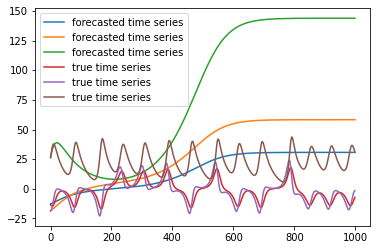

In [21]:
plt.plot(y_pred[:1000,:], label = 'forecasted time series') #100
plt.plot(xt.values[1:1001,:],label = 'true time series') #101
plt.legend()

Text(0, 0.5, 'Lorenz 63 states')

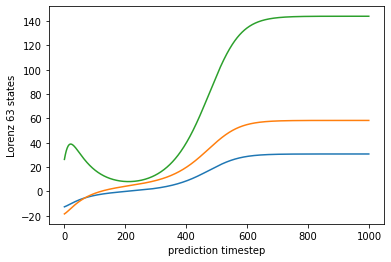

In [22]:
from scipy.interpolate import interp1d
interp_time_step = 0.01
time_step_ratio = GD.dt_integration/interp_time_step
t_new  = np.linspace(0, t_pred, num=int(nb_steps_pred*time_step_ratio), endpoint=True)
t_init = np.linspace(0, t_pred, num=nb_steps_pred, endpoint=True)
RINN_Interp=interp1d(t_init, y_pred,axis=0, kind='cubic')
plt.plot(RINN_Interp(t_new)[:1000,:])
plt.xlabel('prediction timestep'); plt.ylabel('Lorenz 63 states')

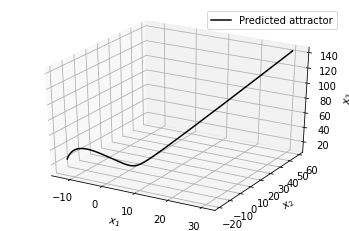

In [23]:
from mpl_toolkits.mplot3d import Axes3D
fig   =plt.figure()
ax    =fig.gca(projection='3d')
line1,=ax.plot(RINN_Interp(t_new)[:,0],RINN_Interp(t_new)[:,1],RINN_Interp(t_new)[:,2],'k')
ax.set_xlabel('$x_1$');ax.set_ylabel('$x_2$');ax.set_zlabel('$x_3$')
plt.legend([line1], ['Predicted attractor'])

Text(0, 0.5, 'Lorenz 63 states')

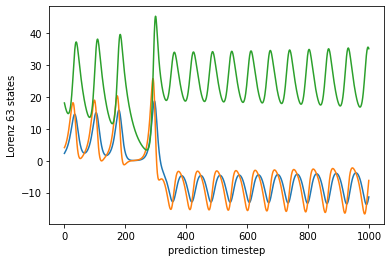

In [24]:
interp_time_step = 0.01
time_step_ratio = GD.dt_integration/interp_time_step
t_new  = np.linspace(0, t_pred, num=int(nb_steps_pred*time_step_ratio), endpoint=True)
t_init = np.linspace(0, t_pred, num=nb_steps_pred, endpoint=True)
true_Interp=interp1d(t_init, catalog.analogs[:y_pred.shape[0],:],axis=0, kind='cubic')
plt.plot(true_Interp(t_new)[:1000,:])
plt.xlabel('prediction timestep'); plt.ylabel('Lorenz 63 states')

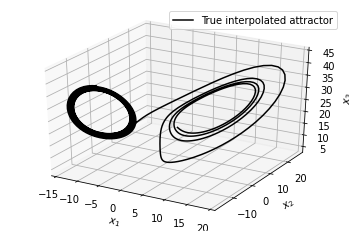

In [25]:
from mpl_toolkits.mplot3d import Axes3D
fig   =plt.figure()
ax    =fig.gca(projection='3d')
line1,=ax.plot(true_Interp(t_new)[:,0],true_Interp(t_new)[:,1],true_Interp(t_new)[:,2],'k')
ax.set_xlabel('$x_1$');ax.set_ylabel('$x_2$');ax.set_zlabel('$x_3$')
plt.legend([line1], ['True interpolated attractor'])

# ISSUE : 

Test with a different integration time step : 

we get a different phase space trajectorie which emphasizes an overfitting of the learnt integration scheme on the training integration time step

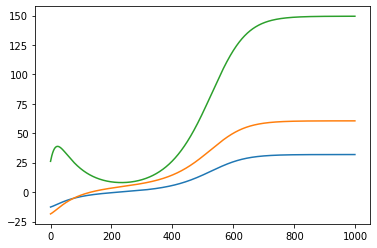

In [26]:
nb_steps_pred = 1000
t_pred = nb_steps_pred * GD.dt_integration
y_pred=np.zeros((nb_steps_pred,params['dim_output']))
tmp = np.reshape(xt.values[0,:],(1,params['dim_output']))
tmp = Variable(torch.from_numpy(tmp).float())

for i in range(nb_steps_pred):
    y_pred[i,:] = dyn_mdl(tmp,0.9*GD.dt_integration,order)[0].data.numpy()
    tmp = Variable(torch.from_numpy(np.reshape(y_pred[i,:] ,(1,params['dim_output']))).float())

plt.plot(y_pred)

### Simulation de dynamiques (séries temporelles) Lorenz_63 stochastique

In [60]:
!pip install sdeint

In [0]:
import sdeint

In [0]:
class GD:
    model = 'Lorenz_63'
    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0/3
        theta = 10.0
    dt_integration = 0.01 # integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8 # number of integration times between consecutive observations (for yo)
    var_obs = np.array([0,1,2]) # indices of the observed variables
    nb_loop_train = 10**2 # size of the catalog
    nb_loop_test = 10 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation
    

In [0]:

def Stoch_Lorenz_63(S,t,sigma=GD.parameters.sigma, rho = GD.parameters.rho, beta = GD.parameters.beta, theta = GD.parameters.theta):
    """ Lorenz-63 dynamical model. """
    x_1 = sigma*(S[1]-S[0])-(4/(2*theta))*S[0];
    x_2 = S[0]*(rho-S[2])-S[1]-(4/(2*theta))*S[1];
    x_3 = S[0]*S[1] - beta*S[2]-(8/(2*theta))*S[2];
    dS  = np.array([x_1,x_2,x_3]);
    return dS

In [0]:
def brownian_process(S,t,sigma=GD.parameters.sigma, rho = GD.parameters.rho, beta = GD.parameters.beta, theta = GD.parameters.theta):
    x_1 = 0.0;
    x_2 = (rho - S[2])/np.sqrt(theta);
    x_3 = (S[1])/np.sqrt(theta);
    dS  = np.array([x_1,x_2,x_3]);
    G = np.zeros((3,3))
    G[0,0] = x_1
    G[1,0] = x_2
    G[2,0] = x_3
    #np.fill_diagonal(G,dS)
    #dim MB=3
    return G

In [0]:
np.random.seed(1)
x0 = np.array([8.0,0.0,30.0]);
tspan = np.arange(0,70+0.000001,10E-5)
S = sdeint.itoEuler(Stoch_Lorenz_63, brownian_process, x0, tspan)

Text(0.5, 0.92, 'Stochastic Lorenz flow')

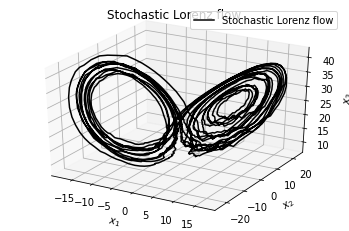

In [66]:
# Undersampling to dt = .01
S_u  = S[::100]
fig=plt.figure()
ax=fig.gca(projection='3d')
line1,=ax.plot(S_u[:2000,0],S_u[:2000,1],S_u[:2000,2],'k')
ax.set_xlabel('$x_1$');ax.set_ylabel('$x_2$');ax.set_zlabel('$x_3$')
plt.legend([line1], ['Stochastic Lorenz flow'])
plt.title('Stochastic Lorenz flow')

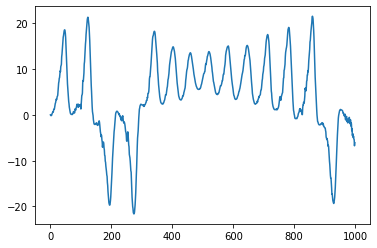

In [67]:
plt.plot(S_u[:1000,1])

In [0]:
def generate_data(GD):
    """ Generate the true state, noisy observations and catalog of numerical simulations. """

    # initialization
    class xt:
        values = [];
        time = [];
    class yo:
        values = [];
        time = [];
    class catalog:
        analogs = [];
        successors = [];
        source = [];
        time = [];
    
    # test on parameters
    if GD.dt_states>GD.dt_obs:
        print('Error: GD.dt_obs must be bigger than GD.dt_states');
    if (np.mod(GD.dt_obs,GD.dt_states)!=0):
        print('Error: GD.dt_obs must be a multiple of GD.dt_states');

    # use this to generate the same data for different simulations
    np.random.seed(1);

    # 5 time steps (to be in the attractor space)  
    x0 = np.array([8.0,0.0,30.0]);
    #S = odeint(Lorenz_63,x0,np.arange(0,5+0.000001,GD.dt_integration),args=(GD.parameters.Pra,GD.parameters.r,GD.parameters.b,GD.parameters.gamma));
    S = sdeint.itoEuler(Stoch_Lorenz_63, brownian_process, x0, tspan)
    x0 = S[S.shape[0]-1,:];

    # generate true state (xt)
    #S = odeint(Lorenz_63,x0,np.arange(0.01,GD.nb_loop_test+0.000001,GD.dt_integration),args=(GD.parameters.Pra,GD.parameters.r,GD.parameters.b,GD.parameters.gamma));
    S = sdeint.itoEuler(Stoch_Lorenz_63, brownian_process, x0, tspan)
    T_test = S.shape[0];      
    t_xt = np.arange(0,T_test,GD.dt_states);       
    xt.time = t_xt*GD.dt_integration;
    xt.values = S[t_xt,:];
        
    # generate  partial/noisy observations (yo)
    eps = np.random.multivariate_normal(np.zeros(3),GD.sigma2_obs*np.eye(3,3),T_test);
    yo_tmp = S[t_xt,:]+eps[t_xt,:];
    t_yo = np.arange(0,T_test,GD.dt_obs);
    i_t_obs = np.where((np.in1d(t_xt,t_yo))==True)[0];
    yo.values = xt.values*np.nan;
    yo.values[np.ix_(i_t_obs,GD.var_obs)] = yo_tmp[np.ix_(i_t_obs,GD.var_obs)];
    yo.time = xt.time;
       

    #generate catalog
    #S =  odeint(Lorenz_63,S[S.shape[0]-1,:],np.arange(0.01,GD.nb_loop_train+0.000001,GD.dt_integration),args=(GD.parameters.Pra,GD.parameters.r,GD.parameters.b,GD.parameters.gamma));
    S = sdeint.itoEuler(Stoch_Lorenz_63, brownian_process, x0, tspan)
    T_train = S.shape[0];
    eta = np.random.multivariate_normal(np.zeros(3),GD.sigma2_catalog*np.eye(3,3),T_train);
    catalog_tmp = S+eta;
    catalog.analogs = catalog_tmp[0:-GD.dt_states,:];
    catalog.successors = catalog_tmp[GD.dt_states:,:]
    catalog.source = GD.parameters;
  # reinitialize random generator number    
    np.random.seed()

    return catalog, xt, yo;

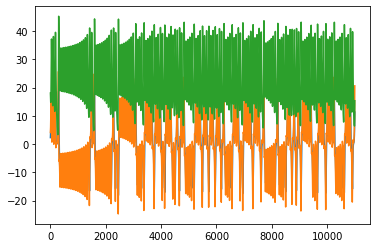

In [69]:
plt.plot(catalog.analogs)

In [0]:
#training data
batch_size = 50
X_train = np.reshape(catalog.analogs,(int(catalog.analogs.shape[0]/batch_size),batch_size,catalog.analogs.shape[1]))
Grad_t  = np.gradient(X_train)[1]/GD.dt_integration
Y_train = np.reshape(catalog.successors,(int(catalog.analogs.shape[0]/batch_size),batch_size,catalog.analogs.shape[1]))

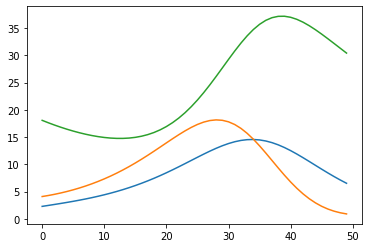

In [71]:
plt.plot(X_train[0,:,:])

In [0]:
params = {}
params['transition_layers']=1
params['bi_linear_layers']=3
params['dim_hidden_linear'] = 3
params['dim_input']=3
params['dim_output']=3
params['dim_observations'] = 3
params['dim_hidden']=3
params['ntrain']=[1000,200]
params['dt_integration'] = GD.dt_integration
pretrained = False
path = ''# to be defined
file_name = '' # to be defined

In [0]:
np.random.seed(0)
torch.manual_seed(0)
class FC_net(torch.nn.Module):
        def __init__(self, params):
            super(FC_net, self).__init__()
            self.linearCell   = torch.nn.Linear(params['dim_input'], params['dim_hidden_linear']) 
            self.BlinearCell1 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1) for i in range(params['bi_linear_layers'])])
            self.BlinearCell2 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1) for i in range(params['bi_linear_layers'])])
            augmented_size    = params['bi_linear_layers'] + params['dim_hidden_linear']
            self.transLayers = torch.nn.ModuleList([torch.nn.Linear(augmented_size, params['dim_input'])])
            self.transLayers.extend([torch.nn.Linear(params['dim_input'],params['dim_input']) for i in range(1, params['transition_layers'])])
            self.outputLayer  = torch.nn.Linear(params['dim_input'], params['dim_input']) 
        def forward(self, inp, dt):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            aug_inp = inp
            BP_outp = (torch.zeros((aug_inp.size()[0],params['bi_linear_layers'])))
            L_outp   = self.linearCell(aug_inp)
            for i in range((params['bi_linear_layers'])):
                BP_outp[:,i]=self.BlinearCell1[i](aug_inp)[:,0]*self.BlinearCell2[i](aug_inp)[:,0]
            aug_vect = torch.cat((L_outp, BP_outp), dim=1)
            for i in range((params['transition_layers'])):
                aug_vect = (self.transLayers[i](aug_vect))
            grad = self.outputLayer(aug_vect)
            return grad
model  = FC_net(params)

In [0]:
class INT_net(torch.nn.Module):
        def __init__(self, params):
            super(INT_net, self).__init__()
#            self.add_module('Dyn_net',FC_net(params))
            self.Dyn_net = model
        def forward(self, inp, dt):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k1 = self.Dyn_net(inp,dt)
            inp_k2      = inp + 0.5*params['dt_integration']*k1
            k2     = self.Dyn_net(inp_k2,dt)
            inp_k3      = inp + 0.5*params['dt_integration']*k2       
            k3     = self.Dyn_net(inp_k3,dt)
            inp_k4      = inp + params['dt_integration']*k3          
            k4     = self.Dyn_net(inp_k4,dt)            
            pred = inp +dt*(k1+2*k2+2*k3+k4)/6    
            return pred, k1

In [0]:
dt = params['dt_integration']
aug_vect = []
x = torch.from_numpy(X_train).float()
y = torch.from_numpy(Y_train).float()
z = torch.from_numpy(Grad_t).float()

modelRINN = INT_net(params)
criterion = torch.nn.MSELoss(reduction='elementwise_mean')
optimizer = torch.optim.Adam(modelRINN.parameters(),lr = 0.001)

if pretrained :
    modelRINN.load_state_dict(torch.load(path + file_name))

In [76]:
print ('Learning Dynamical model')        
for t in range(params['ntrain'][0]):
    for b in range(x.shape[0]):
        # Forward pass: Compute predicted y by passing x to the model
        pred, grad = modelRINN(x[b,:,:],params['dt_integration'])
        # Compute and print loss
        loss = criterion(grad, z[b,:,:])
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Save models
        #torch.save(modelRINN.state_dict(), path + file_name)
    print(t,loss)

Learning Dynamical model


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:13: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


0 tensor(2167.7939, grad_fn=<MseLossBackward>)
1 tensor(1198.2394, grad_fn=<MseLossBackward>)
2 tensor(1420.5103, grad_fn=<MseLossBackward>)
3 tensor(1438.4559, grad_fn=<MseLossBackward>)
4 tensor(1158.2849, grad_fn=<MseLossBackward>)
5 tensor(952.7786, grad_fn=<MseLossBackward>)
6 tensor(770.1275, grad_fn=<MseLossBackward>)
7 tensor(600.9072, grad_fn=<MseLossBackward>)
8 tensor(450.3810, grad_fn=<MseLossBackward>)
9 tensor(325.1045, grad_fn=<MseLossBackward>)
10 tensor(228.3890, grad_fn=<MseLossBackward>)
11 tensor(159.1411, grad_fn=<MseLossBackward>)
12 tensor(112.8520, grad_fn=<MseLossBackward>)
13 tensor(83.5495, grad_fn=<MseLossBackward>)
14 tensor(65.5145, grad_fn=<MseLossBackward>)
15 tensor(54.1657, grad_fn=<MseLossBackward>)
16 tensor(46.2266, grad_fn=<MseLossBackward>)
17 tensor(39.5271, grad_fn=<MseLossBackward>)
18 tensor(32.7767, grad_fn=<MseLossBackward>)
19 tensor(25.7187, grad_fn=<MseLossBackward>)
20 tensor(19.9789, grad_fn=<MseLossBackward>)
21 tensor(18.8498, grad_fn

In [77]:
print ('Optimizing flowmap')        
for t in range(params['ntrain'][1]):
    for b in range(x.shape[0]):
        # Forward pass: Compute predicted y by passing x to the model
        pred, grad = modelRINN(x[b,:,:],params['dt_integration'])
        # Compute and print loss
        loss = criterion(pred, y[b,:,:])
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Save models
        #torch.save(modelRINN.state_dict(), path + file_name)
    print(t,loss)

Optimizing flowmap


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:13: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


0 tensor(2.5277e-05, grad_fn=<MseLossBackward>)
1 tensor(2.3475e-05, grad_fn=<MseLossBackward>)
2 tensor(2.1621e-05, grad_fn=<MseLossBackward>)
3 tensor(1.9730e-05, grad_fn=<MseLossBackward>)
4 tensor(1.7821e-05, grad_fn=<MseLossBackward>)
5 tensor(1.5914e-05, grad_fn=<MseLossBackward>)
6 tensor(1.4044e-05, grad_fn=<MseLossBackward>)
7 tensor(1.2227e-05, grad_fn=<MseLossBackward>)
8 tensor(1.0497e-05, grad_fn=<MseLossBackward>)
9 tensor(8.8786e-06, grad_fn=<MseLossBackward>)
10 tensor(7.3909e-06, grad_fn=<MseLossBackward>)
11 tensor(6.0591e-06, grad_fn=<MseLossBackward>)
12 tensor(4.8929e-06, grad_fn=<MseLossBackward>)
13 tensor(3.8987e-06, grad_fn=<MseLossBackward>)
14 tensor(3.0723e-06, grad_fn=<MseLossBackward>)
15 tensor(2.4051e-06, grad_fn=<MseLossBackward>)
16 tensor(1.8845e-06, grad_fn=<MseLossBackward>)
17 tensor(1.4928e-06, grad_fn=<MseLossBackward>)
18 tensor(1.2151e-06, grad_fn=<MseLossBackward>)
19 tensor(1.0257e-06, grad_fn=<MseLossBackward>)
20 tensor(9.0367e-07, grad_fn=

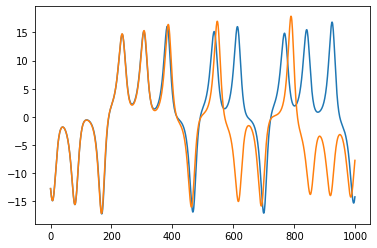

In [78]:
pred = [torch.from_numpy(xt.values[:1,:]).float()]
for i in range(1000):
    pred.append(modelRINN(pred[-1],params['dt_integration'])[0])

plt.plot(torch.stack(pred).data.numpy()[:1000,0,0],label = "Prediction from LQM Dynamical model")
plt.plot(xt.values[:1000,0],label = "True state")

### RINN

In [0]:
import torch.nn.functional as F
from torch.autograd import Variable

def RINN_model(X_train, Y_train, Grad_t, params, order, pretrained, path):
    
    class applyRK_Constraints(object):
        def __init__(self, frequency=1):
            self.frequency = frequency
    
        def __call__(self, module):
            if hasattr(module, 'b'):
                module.b.data = (torch.abs(module.b.data))
                module.b.data  =  ((module.b.data) / (module.b.data).sum(1,keepdim = True).expand_as(module.b.data))
            if hasattr(module, 'c'):
                module.c.data = module.c.data
                module.c.data[:,0] = 0
                module.c.data = module.c.data.sub_(torch.min(module.c.data)).div_(torch.max(module.c.data) - torch.min(module.c.data)).sort()[0]
    torch.manual_seed(1234)
    np.random.seed(1234)    
    class FC_net(torch.nn.Module):
        def __init__(self, params):
            super(FC_net, self).__init__()
            self.linearCell   = torch.nn.Linear(params['dim_input'], params['dim_hidden_linear']) 
            self.BlinearCell1 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1) for i in range(params['bi_linear_layers'])])
            self.BlinearCell2 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1) for i in range(params['bi_linear_layers'])])
            augmented_size    = params['bi_linear_layers'] + params['dim_hidden_linear']
            self.transLayers = torch.nn.ModuleList([torch.nn.Linear(augmented_size, params['dim_output'])])
            self.transLayers.extend([torch.nn.Linear(params['dim_output'], params['dim_output']) for i in range(1, params['transition_layers'])])
            self.outputLayer  = torch.nn.Linear(params['dim_output'], params['dim_output']) 
        def forward(self, inp):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            BP_outp = Variable(torch.zeros((inp.size()[0],params['bi_linear_layers'])))
            L_outp   = self.linearCell(inp)
            for i in range((params['bi_linear_layers'])):
                BP_outp[:,i]=self.BlinearCell1[i](inp)[:,0]*self.BlinearCell2[i](inp)[:,0]
            aug_vect = torch.cat((L_outp, BP_outp), dim=1)
            for i in range((params['transition_layers'])):
                aug_vect = (self.transLayers[i](aug_vect))
            grad = self.outputLayer(aug_vect)
            return grad
    model  = FC_net(params)
    class INT_net(torch.nn.Module):
        def __init__(self, params,order):
            super(INT_net, self).__init__()
            self.Dyn_net = model
            a = np.tril(np.random.uniform(size=(params['dim_observations'],order,order)),k=-1)
            b = np.random.uniform(size=(params['dim_observations'],order))
            c = np.random.uniform(size=(params['dim_observations'],order))
            self.a = torch.nn.Parameter(torch.from_numpy(a[:,:,:]).float())
            self.b = torch.nn.Parameter(torch.from_numpy(b).float())
            self.c = torch.nn.Parameter(torch.from_numpy(c).float())

        def forward(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net(inp))]
            for i in range(1,order):
                coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net(rk_inp))
            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            return pred ,k[0], inp

    x = Variable(torch.from_numpy(X_train).float())
    y = Variable(torch.from_numpy(Y_train).float())
    z = Variable(torch.from_numpy(Grad_t).float())
    # Construct our model by instantiating the class defined above
    
    modelRINN = INT_net(params,order)
    # Construct our loss function and an Optimizer. The call to model.parameters()

    if pretrained :
        modelRINN.load_state_dict(torch.load(path))
    criterion = torch.nn.MSELoss(reduction = 'elementwise_mean')
    optimizer = torch.optim.Adam(modelRINN.parameters(), lr = params['lr'],weight_decay=0.1)
    optimizer.param_groups[0]['params'].append(modelRINN.a)
    optimizer.param_groups[0]['params'].append(modelRINN.b)
    optimizer.param_groups[0]['params'].append(modelRINN.c)    

    clipper = applyRK_Constraints()    
    print ('Learning dynamical model')
    for t in range(params['ntrain'][0]):
        for b in range(x.shape[0]):
            # Forward pass: Compute predicted gradients by passing x to the model
            pred ,grad , inp = modelRINN(x[b,:,:],params['dt_integration'],order)
            # Compute and print loss
            loss = criterion(grad, z[b,:,:])
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
        print(t,loss)

    print ('Learning prediction model')   
    modelRINN.apply(clipper)     
    for t in range(params['ntrain'][1]):
        for b in range(x.shape[0]):
        # Forward pass: Compute predicted states by passing x to the model
            pred ,grad , inp = modelRINN(x[b,:,:],params['dt_integration'],order)
            # Compute and print loss
            loss1 = criterion(pred, y[b,:,:])
            #loss2 = criterion(grad, z[b,:,:])
            loss = 1.0*loss1
            if loss.data.numpy()<1000 and not (np.isnan(loss.data.numpy())):
                # Zero gradients, perform a backward pass, and update the weights.
                optimizer.zero_grad() 
                loss.backward()
                optimizer.step()
                torch.nn.utils.clip_grad_norm_(modelRINN.parameters(),5)
                #modelRINN.apply(clipper)
                if t % clipper.frequency == 0:
                    modelRINN.apply(clipper)     
        print(t,loss)        
    return modelRINN

In [0]:
#training data
batch_size = 100
X_train = np.reshape(catalog.analogs,(int(catalog.analogs.shape[0]/batch_size),batch_size,catalog.analogs.shape[1]))
Grad_t  = np.gradient(X_train)[1]/GD.dt_integration
Y_train = np.reshape(catalog.successors,(int(catalog.analogs.shape[0]/batch_size),batch_size,catalog.analogs.shape[1]))

In [0]:
order=4 #number of stages of the runge kutta scheme (11)

params = {}#NN parameters 
params['transition_layers']=1
params['bi_linear_layers']=3
params['dim_hidden_linear'] = 3
params['dim_input']=3
params['dim_observations'] = 3
params['dim_output']=3
params['dim_hidden']=3
params['dt_integration']=GD.dt_integration
params['ntrain']=[100,1000]
params['lr']=0.001
pretrained = False
path = ''

### Learn dynamical and integration models, stop when loss ~ 0.2

In [91]:
dyn_mdl = RINN_model(X_train, Y_train, Grad_t, params, order, pretrained ,path)

Learning dynamical model


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:13: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


0 tensor(3804.0576, grad_fn=<MseLossBackward>)
1 tensor(3103.0867, grad_fn=<MseLossBackward>)
2 tensor(2851.0818, grad_fn=<MseLossBackward>)
3 tensor(2828.6567, grad_fn=<MseLossBackward>)
4 tensor(2742.5459, grad_fn=<MseLossBackward>)
5 tensor(2556.3210, grad_fn=<MseLossBackward>)
6 tensor(2288.9080, grad_fn=<MseLossBackward>)
7 tensor(1943.3983, grad_fn=<MseLossBackward>)
8 tensor(1589.6705, grad_fn=<MseLossBackward>)
9 tensor(1336.1157, grad_fn=<MseLossBackward>)
10 tensor(1181.2959, grad_fn=<MseLossBackward>)
11 tensor(1082.4827, grad_fn=<MseLossBackward>)
12 tensor(1019.0656, grad_fn=<MseLossBackward>)
13 tensor(975.4114, grad_fn=<MseLossBackward>)
14 tensor(938.4205, grad_fn=<MseLossBackward>)
15 tensor(899.6633, grad_fn=<MseLossBackward>)
16 tensor(854.2006, grad_fn=<MseLossBackward>)
17 tensor(798.8478, grad_fn=<MseLossBackward>)
18 tensor(731.3865, grad_fn=<MseLossBackward>)
19 tensor(650.8683, grad_fn=<MseLossBackward>)
20 tensor(558.5889, grad_fn=<MseLossBackward>)
21 tensor(

In [0]:
torch.save(dyn_mdl.state_dict(), 'Model_L63_RK4_h_04_1.pt')

In [0]:
nb_steps_pred = 1000
t_pred = nb_steps_pred * GD.dt_integration
y_pred=np.zeros((nb_steps_pred,params['dim_output']))
tmp = np.reshape(xt.values[0,:],(1,params['dim_output']))
tmp = Variable(torch.from_numpy(tmp).float())

for i in range(nb_steps_pred):
    y_pred[i,:] = dyn_mdl(tmp,GD.dt_integration,order)[0].data.numpy()
    tmp = Variable(torch.from_numpy(np.reshape(y_pred[i,:] ,(1,params['dim_output']))).float())

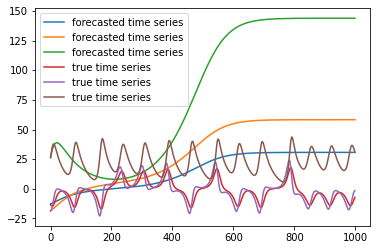

In [85]:
plt.plot(y_pred[:1000,:], label = 'forecasted time series') #100
plt.plot(xt.values[1:1001,:],label = 'true time series') #101
plt.legend()

Text(0, 0.5, 'Lorenz 63 states')

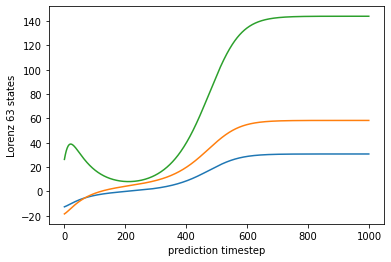

In [86]:
from scipy.interpolate import interp1d
interp_time_step = 0.01
time_step_ratio = GD.dt_integration/interp_time_step
t_new  = np.linspace(0, t_pred, num=int(nb_steps_pred*time_step_ratio), endpoint=True)
t_init = np.linspace(0, t_pred, num=nb_steps_pred, endpoint=True)
RINN_Interp=interp1d(t_init, y_pred,axis=0, kind='cubic')
plt.plot(RINN_Interp(t_new)[:1000,:])
plt.xlabel('prediction timestep'); plt.ylabel('Lorenz 63 states')

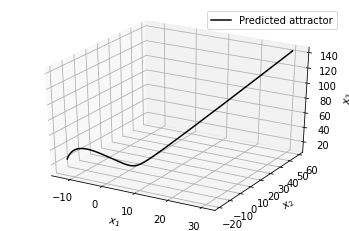

In [87]:
from mpl_toolkits.mplot3d import Axes3D
fig   =plt.figure()
ax    =fig.gca(projection='3d')
line1,=ax.plot(RINN_Interp(t_new)[:,0],RINN_Interp(t_new)[:,1],RINN_Interp(t_new)[:,2],'k')
ax.set_xlabel('$x_1$');ax.set_ylabel('$x_2$');ax.set_zlabel('$x_3$')
plt.legend([line1], ['Predicted attractor'])

Text(0, 0.5, 'Lorenz 63 states')

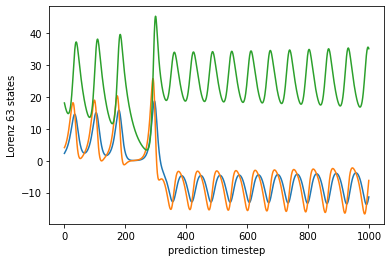

In [88]:
interp_time_step = 0.01
time_step_ratio = GD.dt_integration/interp_time_step
t_new  = np.linspace(0, t_pred, num=int(nb_steps_pred*time_step_ratio), endpoint=True)
t_init = np.linspace(0, t_pred, num=nb_steps_pred, endpoint=True)
true_Interp=interp1d(t_init, catalog.analogs[:y_pred.shape[0],:],axis=0, kind='cubic')
plt.plot(true_Interp(t_new)[:1000,:])
plt.xlabel('prediction timestep'); plt.ylabel('Lorenz 63 states')

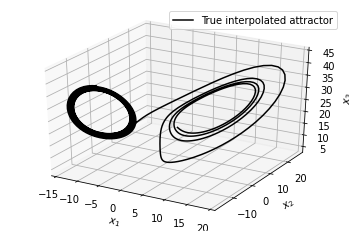

In [89]:
from mpl_toolkits.mplot3d import Axes3D
fig   =plt.figure()
ax    =fig.gca(projection='3d')
line1,=ax.plot(true_Interp(t_new)[:,0],true_Interp(t_new)[:,1],true_Interp(t_new)[:,2],'k')
ax.set_xlabel('$x_1$');ax.set_ylabel('$x_2$');ax.set_zlabel('$x_3$')
plt.legend([line1], ['True interpolated attractor'])

# ISSUE : 

Test with a different integration time step : 

we get a different phase space trajectorie which emphasizes an overfitting of the learnt integration scheme on the training integration time step

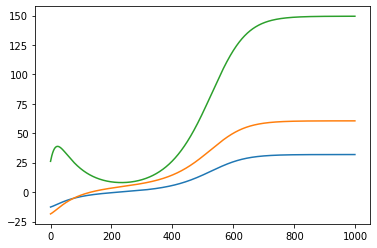

In [90]:
nb_steps_pred = 1000
t_pred = nb_steps_pred * GD.dt_integration
y_pred=np.zeros((nb_steps_pred,params['dim_output']))
tmp = np.reshape(xt.values[0,:],(1,params['dim_output']))
tmp = Variable(torch.from_numpy(tmp).float())

for i in range(nb_steps_pred):
    y_pred[i,:] = dyn_mdl(tmp,0.9*GD.dt_integration,order)[0].data.numpy()
    tmp = Variable(torch.from_numpy(np.reshape(y_pred[i,:] ,(1,params['dim_output']))).float())

plt.plot(y_pred)